In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Force TF to use only the CPU

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean 
from insightface.embedder import InsightfaceEmbedder
import pandas as pd
from glob import glob
from tqdm import tqdm
from time import time
import IPython


model_path = "models/model-r34-amf/model"
embedder = InsightfaceEmbedder(model_path=model_path, epoch_num='0000', image_size=(112, 112),
                               no_face_raise=False,
                               MTCNN_min_face_size=50, MTCNN_steps_threshold=[0.7, 0.7, 0.9])

Using TensorFlow backend.


loading models/model-r34-amf/model 0


# Create database of embeddings

In [4]:
dfPeople = pd.DataFrame()
dfPeople['name'] = 'object'
dfPeople['path'] = 'object'
dfPeople['embedding'] = 'object'
dfPeople['bbox'] = 'object'

faceDetection_imgHeight = 512

path = 'data/People/'

def get_embeddings(path):
    people_list = os.listdir(path)
    
    count = 0
    print(f'Обнаружено {len(people_list)} индивидов')
    print(f'Создание базы эмбеддингов')
    
    for man in tqdm(people_list):
        photos = os.listdir(f'data/People/{man}')
        for photo in photos:
            img_path = f'data/People/{man}/{photo}'
            img = cv2.imread(img_path)
            emb_img, bboxes_img, points = embedder.embed_image(img, faceDetection_imgHeight=faceDetection_imgHeight)
            dfPeople.at[count, 'name'] = man
            dfPeople.at[count, 'path'] = img_path
            dfPeople.at[count, 'embedding'] = emb_img[0]
            dfPeople.at[count, 'bbox']      = bboxes_img[0]
            count += 1
    return dfPeople

dfPeople = get_embeddings(path)

  0%|          | 0/4 [00:00<?, ?it/s]

Обнаружено 4 индивидов
Создание базы эмбеддингов


100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


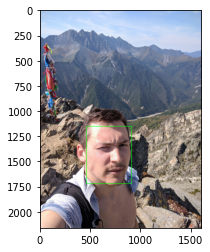

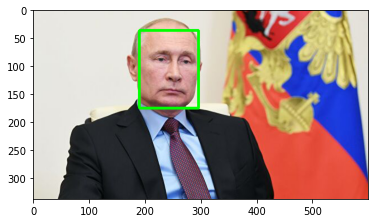

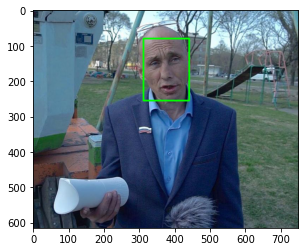

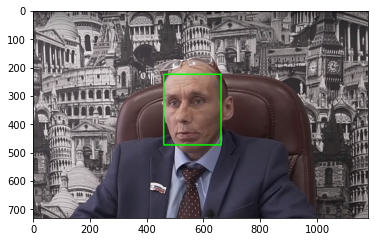

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


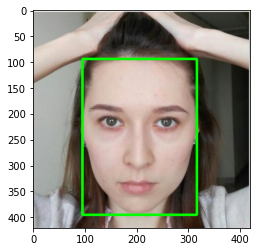

In [5]:
def show_baza(dfPeople):
    for i in dfPeople.index:
        path = dfPeople.at[i, 'path']
        img = plt.imread(path)
        startPoint = dfPeople.at[i, 'bbox'][:2]
        endPoint = dfPeople.at[i, 'bbox'][2:4]
        cv2.rectangle(img, tuple(startPoint), tuple(endPoint), (0,255,0), 4)
        plt.imshow(img)
        plt.show()
        
### Averagin embedding
def average_embeddings(dfPeople):
    df = pd.DataFrame()
    df['name'] = 'name'
    df['embedding'] = 'embedding'

    for ind, name in enumerate(dfPeople['name'].value_counts().index):
        person = dfPeople[dfPeople['name'] == name]
        df.at[ind, 'name'] = name
        df.at[ind, 'embedding'] = np.average(person['embedding'].values, axis=0)
    return df

def process_frame(bgr_frame, faceDetection_imgHeight, tolerance):
    # Find all the faces and face encodings in the current frame of video
    face_encodings, face_locations, face_points = embedder.embed_image(bgr_frame, faceDetection_imgHeight=faceDetection_imgHeight)
    if face_encodings != None:
        face_names = []
        dists_list = []
        for face_encoding in face_encodings:
            # See if the face is a match for the known face(s)
            distances = np.linalg.norm(dfPeople['embedding'].values.tolist() - face_encoding, axis=1)
            matches = distances <= tolerance
            min_dist = min(distances)
            dists_list.append(min_dist)
            name = 'Unknown'
            if matches.sum() > 0:
                name = dfPeople['name'][matches].value_counts().index[0]
            face_names.append(name)

        # Label the results
        ind = 0
        for (left, top, right, bottom), name in zip(face_locations, face_names):
            # Draw a box around the face
            # Draw a label with a name below the face
            cv2.rectangle(bgr_frame, (left, top), (right, bottom), (0, 255, 0), 4)
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(bgr_frame, f"{name}, {str(dists_list[ind])[:4]}", (left, bottom), font, 
                        0.7, (0, 255, 0), 1)
            ind += 1

    return bgr_frame

#Mobilenet - 21.42. sec length of the descriptor - 128 -
#Resnet34 - 41 sec. length of the descriptor - 512 - 
#Resnet100 - 81 sec. length of the descriptor - 512 - 
show_baza(dfPeople)

# Running face recognition from camera

In [7]:
faceDetection_imgHeight=300
video_capture = cv2.VideoCapture(0)

ret, frame = video_capture.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)

while True:
    ret, bgr_frame = video_capture.read()
    frame = process_frame(bgr_frame, faceDetection_imgHeight, tolerance=1)
    _, frame = cv2.imencode('.jpg', frame) 
    i = IPython.display.Image(data=frame)
    IPython.display.display(i)
    IPython.display.clear_output(wait=True)

error: OpenCV(4.2.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [8]:
# Run this cell to stop the camera
video_capture.release()